# **Comparative Analysis of Decision Tree Ensemble Models for EEG Classification**
<a target="_blank" href="https://colab.research.google.com/github/KingPhito/BCI-EEG-Research/blob/develop/notebooks/kaggle-eeg-tree-ensembles.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook is a comparative analysis of tree ensemble models for EEG classification. I will be evaluating the performance of the following models:
1. Random Forest
2. Gradient Boosting

I will be using a simple pipeline to preprocess the data and train the models. The pipeline will consist of the following steps:
1. Feature extraction from the EEG channels Using Common Spatial Patterns (CSP).
2. Multi label classification using the tree ensemble models mentioned above.

I will be performing a grid search for hyper-parameter tuning of each model, and then will also be using five fold cross validation to hopefully protect against overfitting.
I will compare the performance of the models using the following metrics:
1. Precision
2. Recall
3. F1 Score
4. Confusion Matrix

I am using data from this [Grasp-and-Lift EEG Detection](https://www.kaggle.com/c/grasp-and-lift-eeg-detection/) competition. The data consists of EEG recordings from 32 channels for 10 subjects. The data is divided into 45 trials for each subject. Each trial consists of 6 events. The goal is to predict the labels of each sample in the test set. This competition is from 2015, but it serves as an excellent data set for benchmarking EEG event detection algorithms.This will also allow me to test the effectiveness of these models against all the submissions to this competition.

I was inspired by the work being done at Stanford University on [NOIR: Neural Signal Operated Intelligent Robots](https://noir-corl.github.io/). They are using CSP And quadratic discriminate analysis(QDA) to process EEG signals, and have had amazing results with study participants being able to control robots. The data set I am working with here however is structured as a multi label classification problem, so I opted To compare the efficacy of tree ensembles in place of QDA. I believe that EEG signals have the potential to revolutionize human-computer interaction, especially for people with physical disabilities like myself. I hope that this notebook will inspire others to work on EEG event detection and other EEG applications.

## **Install The Libraries**
First we install install all necessary Python libraries. Check the [README.md](../README.md) file for more info on how to do this.

## **Kaggle Environment Setup**
You will need to upload your *kaggle.json*, set the permissions so the file can be read.

In [44]:
!chmod 600 ../kaggle.json

Then we set the Kaggle configuration directory to our current working directory, as an environment variable.

In [45]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '../'

Now we can download the data from the competition page, 

In [3]:
if not os.path.exists('../data/kaggle-eeg'):
    os.makedirs('../data/kaggle-eeg')
    !kaggle competitions download grasp-and-lift-eeg-detection -p ../data/kaggle-eeg/ -f train.zip
    !unzip ../data/kaggle-eeg/train.zip -d ../data/kaggle-eeg

## **Imports**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import LabelBinarizer
pd.set_option('display.max_columns', None)


## **Data Analysis**
Here we load one series from one subject to see what the data looks like. As expected we have 32 columns representing the EEG channels, and 6 columns representing the events. The events are binary, with 1 representing the start of an event, and 0 representing the absence of an event.

In [5]:
data_path = '../data/kaggle-eeg/train'
features = pd.read_csv(f'{data_path}/subj1_series1_data.csv')
labels = pd.read_csv(f'{data_path}/subj1_series1_events.csv')
features = features.drop(columns=['id'])
labels = labels.drop(columns=['id'])

display(features.info(), features.describe(), features.head(), labels.info(), labels.describe(), labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119496 entries, 0 to 119495
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Fp1     119496 non-null  int64
 1   Fp2     119496 non-null  int64
 2   F7      119496 non-null  int64
 3   F3      119496 non-null  int64
 4   Fz      119496 non-null  int64
 5   F4      119496 non-null  int64
 6   F8      119496 non-null  int64
 7   FC5     119496 non-null  int64
 8   FC1     119496 non-null  int64
 9   FC2     119496 non-null  int64
 10  FC6     119496 non-null  int64
 11  T7      119496 non-null  int64
 12  C3      119496 non-null  int64
 13  Cz      119496 non-null  int64
 14  C4      119496 non-null  int64
 15  T8      119496 non-null  int64
 16  TP9     119496 non-null  int64
 17  CP5     119496 non-null  int64
 18  CP1     119496 non-null  int64
 19  CP2     119496 non-null  int64
 20  CP6     119496 non-null  int64
 21  TP10    119496 non-null  int64
 22  P7      119496 non-n

None

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,265.934374,404.173194,398.503774,215.615385,144.392189,443.437395,-122.864221,474.953538,88.350681,16.658583,325.775624,-72.496017,164.679822,8.043031,297.241439,296.862715,144.547608,-0.888189,112.011406,234.946877,27.035206,85.143754,450.076714,211.734401,188.356271,162.037800,368.885569,102.616556,305.008302,28.207438,67.214919,155.612497
std,373.911366,313.686274,207.645572,204.065055,141.130921,221.457186,479.160803,198.874064,113.654894,124.604345,317.959455,654.323615,160.777132,104.530898,141.144494,1281.825049,1166.903290,158.022883,159.564132,155.383882,233.517355,587.479539,222.096432,151.240938,189.787461,267.063408,248.232282,212.856072,202.580586,188.116823,256.458072,225.393451
min,-1051.000000,-532.000000,-752.000000,-466.000000,-262.000000,-634.000000,-4095.000000,-893.000000,-300.000000,-517.000000,-4119.000000,-4759.000000,-437.000000,-375.000000,-864.000000,-6541.000000,-1852.000000,-866.000000,-304.000000,-298.000000,-1848.000000,-3563.000000,-1283.000000,-378.000000,-427.000000,-1207.000000,-1057.000000,-908.000000,-666.000000,-822.000000,-888.000000,-948.000000
25%,43.000000,218.000000,253.000000,76.000000,37.000000,300.000000,-378.000000,341.000000,24.000000,-59.000000,124.000000,-337.000000,52.000000,-68.000000,207.000000,85.000000,-184.000000,-107.000000,4.000000,131.000000,-152.000000,-151.000000,304.000000,111.000000,68.000000,16.000000,213.000000,-41.000000,167.000000,-97.000000,-118.000000,15.000000
50%,210.000000,360.000000,389.000000,210.000000,123.000000,431.000000,-190.000000,469.000000,95.000000,15.000000,321.000000,-109.000000,167.000000,0.000000,281.000000,280.000000,38.000000,1.000000,86.000000,210.000000,33.000000,61.000000,445.000000,205.000000,161.000000,176.000000,361.000000,85.000000,307.000000,32.000000,45.000000,134.000000
75%,404.000000,515.000000,534.000000,356.000000,242.000000,566.000000,30.000000,606.000000,147.000000,93.000000,537.000000,143.000000,274.000000,77.000000,378.000000,508.000000,233.000000,102.000000,185.000000,315.000000,201.000000,263.000000,595.000000,307.000000,266.000000,346.000000,518.000000,232.000000,446.000000,154.000000,246.000000,264.000000
max,3101.000000,3047.000000,1479.000000,1253.000000,801.000000,2417.000000,5111.000000,3203.000000,545.000000,665.000000,9011.000000,4844.000000,969.000000,376.000000,2158.000000,11312.000000,8322.000000,865.000000,815.000000,907.000000,1736.000000,4184.000000,2088.000000,788.000000,1140.000000,879.000000,1400.000000,1611.000000,1074.000000,859.000000,978.000000,1326.000000


,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


None

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
count,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000,119496.000000
mean,0.042679,0.042679,0.042679,0.042679,0.042679,0.042679
std,0.202134,0.202134,0.202134,0.202134,0.202134,0.202134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


Here I made some convenience functions For loading a series from each subject, and merge them into one dataframe.

In [6]:
label_names = labels.columns

def load_series_data(subject, series):
    features = pd.read_csv(f'{data_path}/subj{subject}_series{series}_data.csv')
    labels = pd.read_csv(f'{data_path}/subj{subject}_series{series}_events.csv')
    return features, labels

def merge_labels(features, labels):
    data = features.copy()
    data = data.merge(labels, on='id')
    data.drop(columns=['id'], inplace=True)
    return data

def get_training_batch(series):
    features, labels = load_series_data(1, series)
    data = merge_labels(features, labels)
    for i in range(2, 13):
        features, labels = load_series_data(i, series)
        data = pd.concat([data, merge_labels(features, labels)])
    return data

analysis_data = get_training_batch(1)
analysis_data.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704,0,0,0,0,0,0
1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737,0,0,0,0,0,0
2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677,0,0,0,0,0,0
3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592,0,0,0,0,0,0
4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581,0,0,0,0,0,0


I'm still learning a lot about EEG data, And I thought a correlation matrix would be helpful to see if there are any relationships between the EEG channels. I will be using the Pearson correlation coefficient to calculate the correlation matrix.

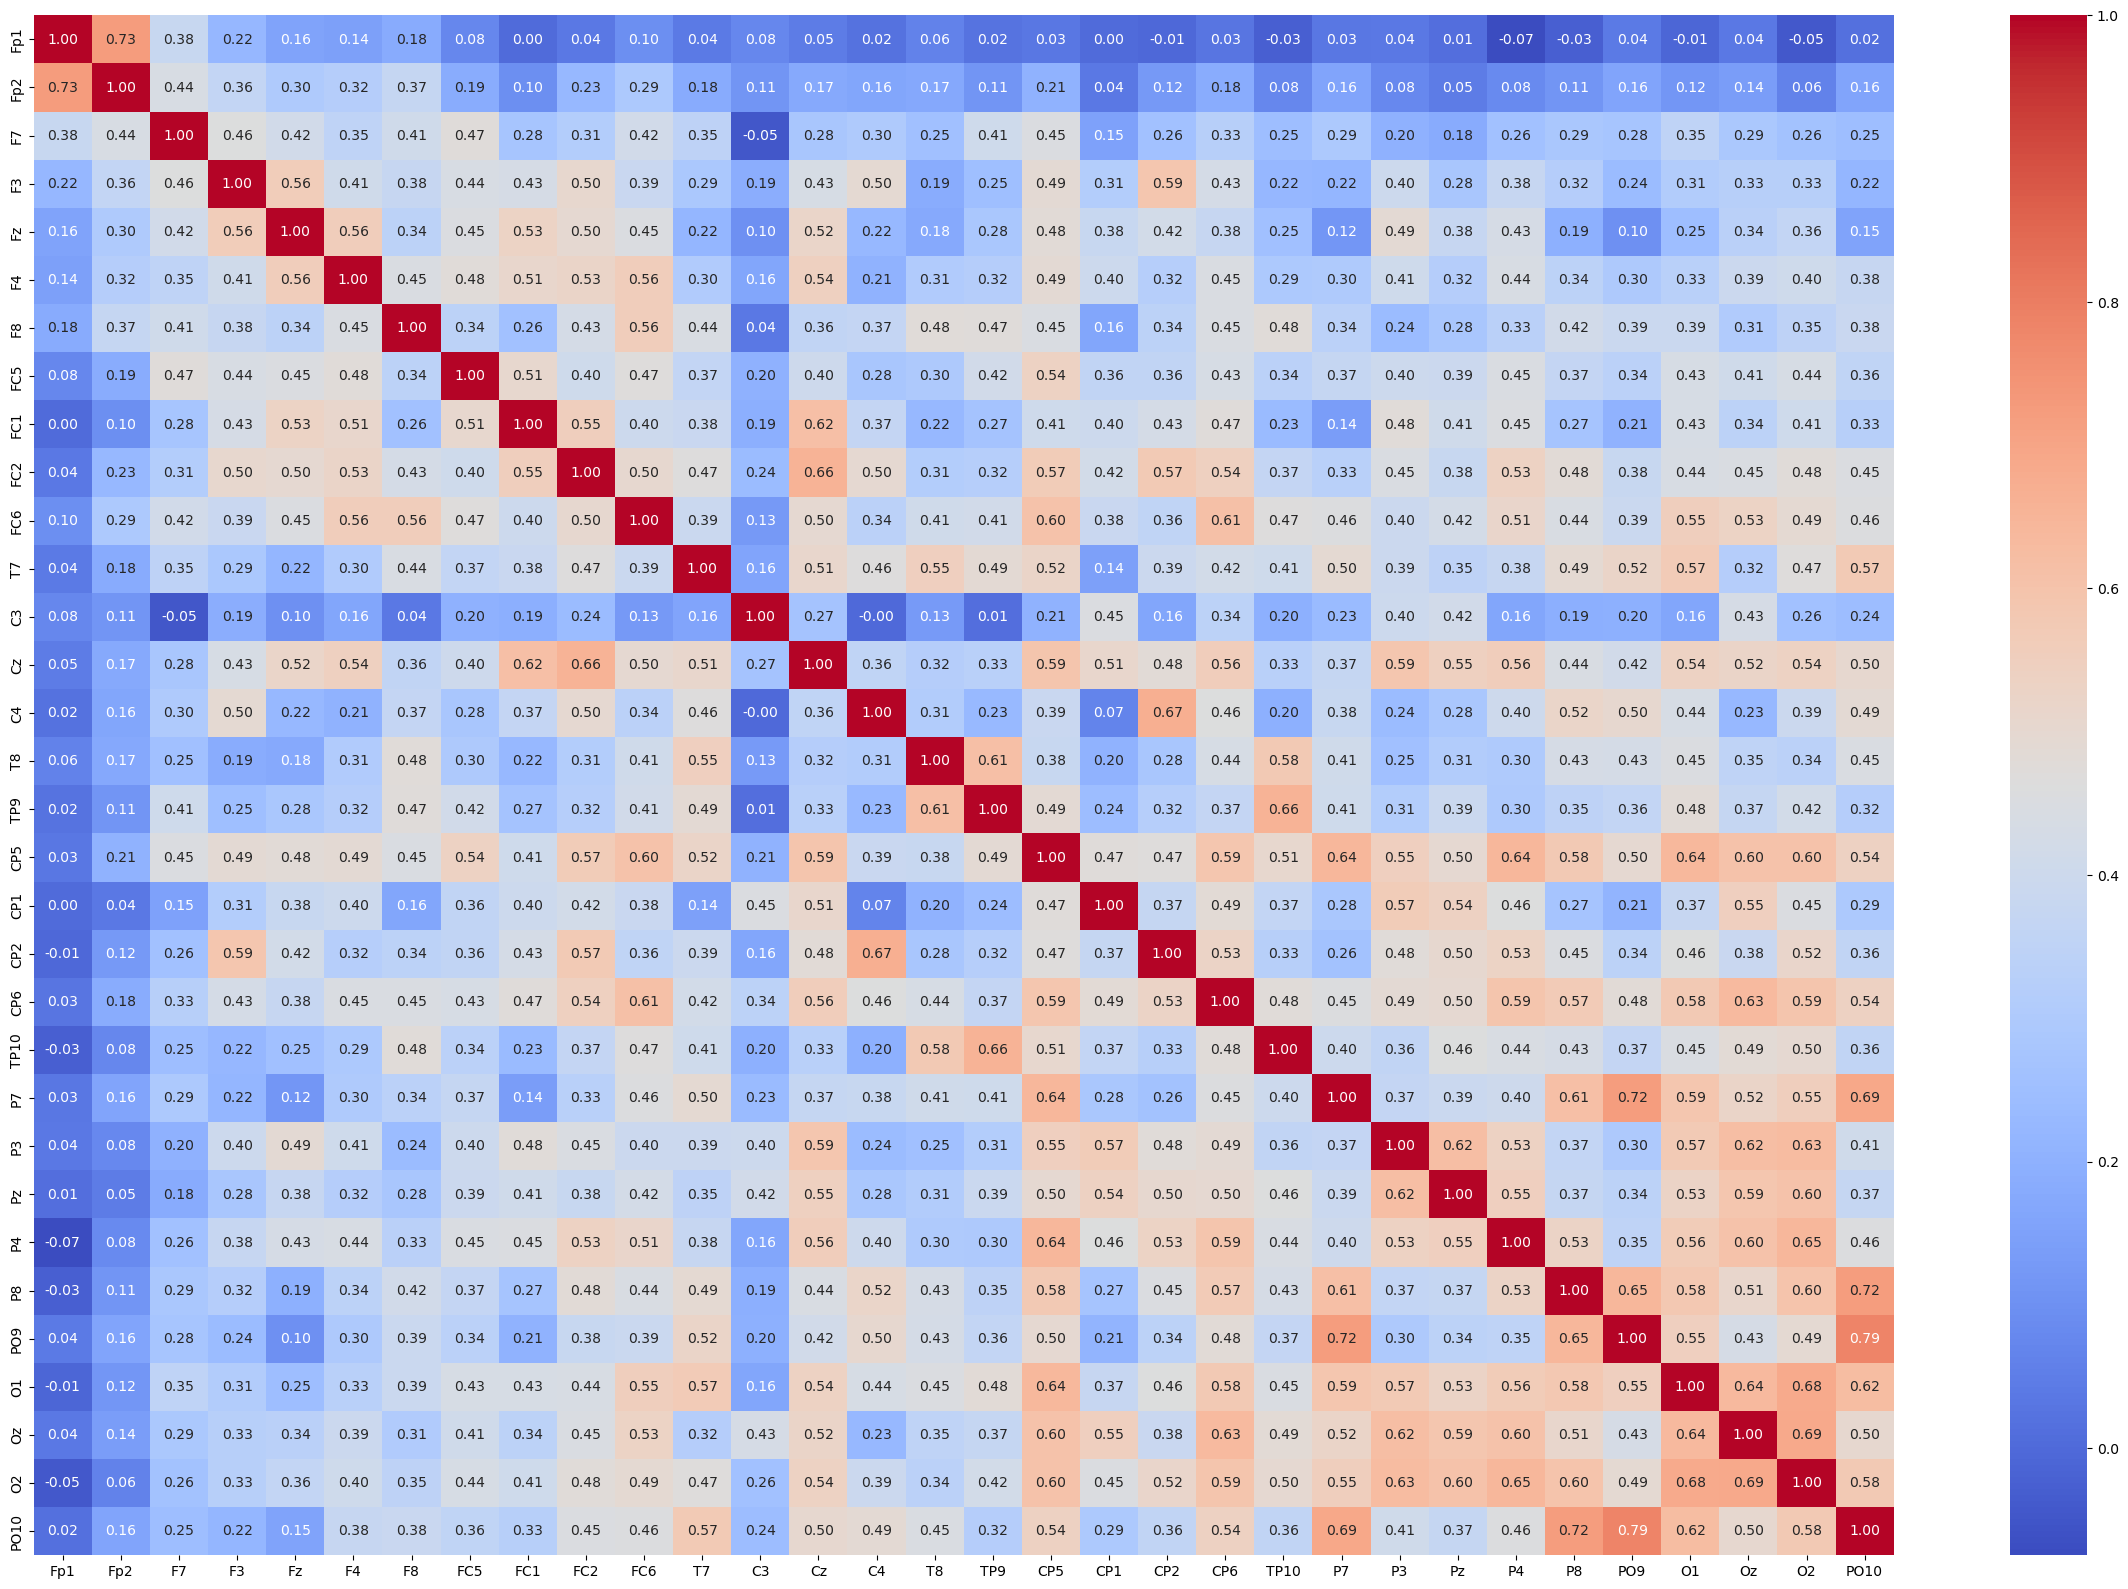

In [7]:
corr = analysis_data.drop(columns=label_names).corr(method='pearson')
plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## **Modeling**

### **Data Preprocessing**

In [8]:
train_df = get_training_batch(1)
train_df.shape

(2444189, 38)

Here I am checking for imbalances in the data. Since we are using tree ensemble models, I don't think imbalances will be a problem, but it's always good to check.If it turns out to be an issue, I will use the SMOTE algorithm to balance the data.

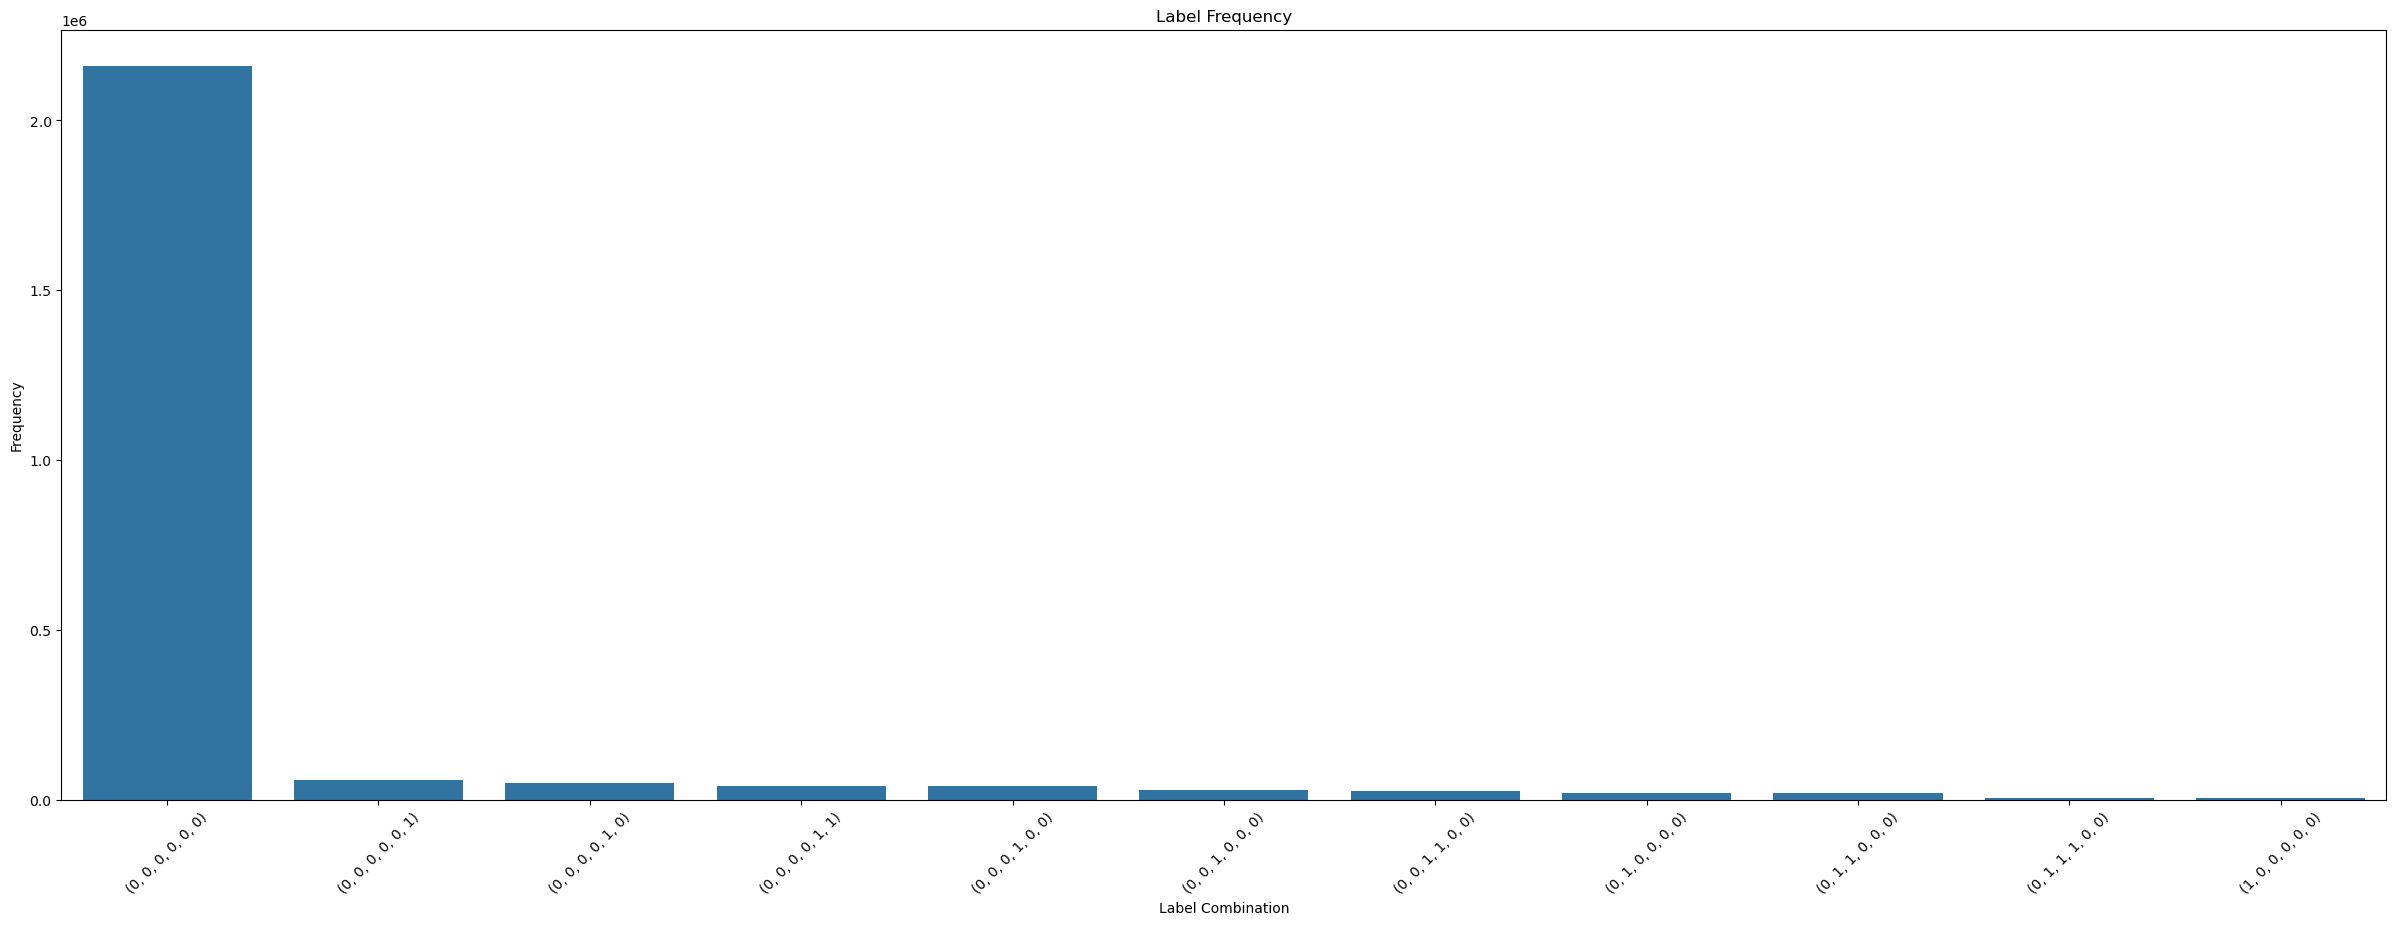

In [9]:
labels = train_df[label_names]
unique_label_combinations, counts = np.unique(labels, axis=0, return_counts=True)

plt.figure(figsize=(30, 10))
sns.barplot(x=range(len(unique_label_combinations)), y=counts, order=np.argsort(counts)[::-1])
plt.title('Label Frequency')
# Convert the numpy array of arrays to a list of tuples for display
xtick_labels = [tuple(row) for row in unique_label_combinations]
plt.xticks(range(len(unique_label_combinations)), xtick_labels, rotation=45)
plt.xlabel('Label Combination')
plt.ylabel('Frequency')
plt.show()

In [10]:
# reshape data for CSP
def reshape_data(data, label_binarizer=LabelBinarizer()):
    X = data.drop(columns=label_names).values
    y = data[label_names].values
    y = y.astype(np.float64)
    y = label_binarizer.fit_transform(y)
    X = np.expand_dims(X, axis=2)
    X = X.astype(np.float64)
    return X, y

X_train, y_train = reshape_data(train_df)
X_train = X_train.astype('float64').copy()
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((2444189, 32, 1), (2444189, 6), dtype('float64'), dtype('int64'))

### **Model Building**
Scikit-learn Has some nice utilities for building pipelines. The following code will build a pipeline for each model that includes the CSP feature extraction step, and the model training step. After that it creates a one-vs-rest classifier for multi label classification. The one-vs-rest classifier is necessary because CSP only works with binary classification.

#### Random Forest Model

In [11]:
best_params = {
    'CSP__n_components': 4,
    'RF__ccp_alpha': 0.0,
    'RF__max_depth': 7,
    'RF__min_samples_leaf': 1,
    'RF__min_samples_split': 2,
    'RF__n_estimators': 50

}
csp = CSP(n_components=best_params['CSP__n_components'])
rf = RandomForestClassifier(
    n_estimators=best_params['RF__n_estimators'], 
    max_depth=best_params['RF__max_depth'], 
    min_samples_split=best_params['RF__min_samples_split'], 
    min_samples_leaf=best_params['RF__min_samples_leaf'], 
    ccp_alpha=best_params['RF__ccp_alpha']
)
best_rf_pipeline = Pipeline([('CSP', csp), ('RF', rf)])
rf_ovr = OneVsRestClassifier(best_rf_pipeline)
rf_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_ovr, X_train, y_train, cv=rf_cv, scoring='accuracy')
print("Cross-validation scores: ", scores)

Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMP

#### Gradient Boosting Model

In [ ]:
best_params = {
    'CSP__n_components': 4,
    'GB__n_estimators': 200,
    'GB__max_depth': 7,
    'GB__min_samples_split': 2,
    'GB__min_samples_leaf': 1,
    'GB__ccp_alpha': 0.0,
    'GB__learning_rate': 0.1,
    'GB__subsample': 0.7

}
csp = CSP(n_components=best_params['CSP__n_components'])
gb = GradientBoostingClassifier(
    n_estimators=best_params['GB__n_estimators'], 
    max_depth=best_params['GB__max_depth'], 
    min_samples_split=best_params['GB__min_samples_split'], 
    min_samples_leaf=best_params['GB__min_samples_leaf'], 
    ccp_alpha=best_params['GB__ccp_alpha'],
    learning_rate=best_params['GB__learning_rate'],
    subsample=best_params['GB__subsample']
)
best_gb_pipeline = Pipeline([('CSP', csp), ('GB', gb)])
gb_ovr = OneVsRestClassifier(best_gb_pipeline)
gb_cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(gb_ovr, X_train, y_train, cv=gb_cv, scoring='accuracy')
print("Cross-validation scores: ", scores)

### **Training Loop**
Here is my training loop. I will use it to train each model on the data, and then evaluate the performance of each model using the metrics mentioned above.

In [21]:
def training_loop(model: OneVsRestClassifier):
    total_test_x = None
    total_test_y = None
    for series in range(1,9):
        train_df = get_training_batch(series)
        X_train, y_train = reshape_data(train_df)
        train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        model.fit(train_x, train_y)
        series_score = accuracy_score(test_y, model.predict(test_x))
        total_test_x = test_x if total_test_x is None else np.concatenate([total_test_x, test_x])
        total_test_y = test_y if total_test_y is None else np.concatenate([total_test_y, test_y])
        print(f"Series {series} score: {series_score}")
    y_pred = model.predict(total_test_x)
    accuracy = accuracy_score(total_test_y, y_pred)
    report = classification_report(total_test_y, y_pred)
    return accuracy, report, multilabel_confusion_matrix(total_test_y, y_pred, labels=label_names)

### **Training and Evaluation**

#### Random Forest Model

In [19]:
rf_accuracy, rf_report, rf_confusion_matrix = training_loop(rf_ovr)
print(f"Random Forest accuracy: {rf_accuracy}")
print(rf_report)

Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 32 dim * 1.8e+18  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMP

/home/rdugue/miniconda3/envs/eeg-research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rdugue/miniconda3/envs/eeg-research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rdugue/miniconda3/envs/eeg-research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

Random Forest accuracy: 0.8720858211797438
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     94045
           1       0.00      0.00      0.00     93131
           2       0.00      0.00      0.00     93076
           3       0.08      0.00      0.00     93589
           4       0.00      0.00      0.00     93867
           5       0.03      0.00      0.00     93921

   micro avg       0.16      0.00      0.00    561629
   macro avg       0.07      0.00      0.00    561629
weighted avg       0.07      0.00      0.00    561629
 samples avg       0.00      0.00      0.00    561629



In [26]:
features = train_df.drop(columns=label_names)
features.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(30, 10))



for i in range(6):
    estimator = rf_ovr.estimators_[i]
    importances = estimator[1].feature_importances_
    df_importance = pd.DataFrame(data={'Feature': features.columns, 'Importance': importances})
    df_importance = df_importance.sort_values('Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=df_importance, ax=ax[i//2+1, i%2])
    ax[i//2+1, i%2].set_title(f'Feature Importances for Label {rf_ovr.classes_[i]}')
    ax[i//2+1, i%2].set_xlabel('Feature')
    ax[i//2+1, i%2].set_ylabel('Importance')

plt.tight_layout()
plt.show()

#### Gradient Boosting Model

In [ ]:
gb_accuracy, gb_report, gb_confusion_matrix = training_loop(best_gb_pipeline)
print(f"Gradient Boosting accuracy: {gb_accuracy}")
print(gb_report)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(30, 10))

ConfusionMatrixDisplay(gb_confusion_matrix[0]).plot(ax=ax[0])

for i in range(6):
    estimator = gb_ovr.estimators_[i]
    importances = estimator[1].feature_importances_
    indices = np.argsort(importances)[::-1]
    sns.barplot(x=features, y=importances[indices], ax=ax[i//2+1, i%2])
    ax[i//2+1, i%2].set_title(f'Feature Importances for Label {gb_ovr.classes_[i]}')
    ax[i//2+1, i%2].set_xlabel('Feature')
    ax[i//2+1, i%2].set_ylabel('Importance')
plt.show()

## **Submission**
We're gonna download the testing data now from the Kaggle competition and unzip into the data directory.

In [ ]:
!kaggle competitions download grasp-and-lift-eeg-detection -f test.zip

In [ ]:
!unzip ../data/kaggle-eeg/test.zip -d ../data/kaggle-eeg

Here we load the sample submission from the Kaggle competition. This gives us a pre-made dataframe and we just need to update column values with predictions from our model. 

In [ ]:
!kaggle competitions download grasp-and-lift-eeg-detection -f sample_submission.csv.zip

In [ ]:
!unzip ../data/kaggle-eeg/sample_submission.csv.zip -d ../data/kaggle-eeg

In [27]:
sub = pd.read_csv('../data/kaggle-eeg/sample_submission.csv')

In [28]:
sub.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series9_0,0,0,0,0,0,0
1,subj1_series9_1,0,0,0,0,0,0
2,subj1_series9_2,0,0,0,0,0,0
3,subj1_series9_3,0,0,0,0,0,0
4,subj1_series9_4,0,0,0,0,0,0


Here we create a dataframe in the same shape as the example submission on the competition page.

In [29]:
path = '../data/kaggle-eeg/test'

def get_merged_tests():
  tests = None
  for sj in range(1, 13):
    for sr in range(9, 11):
      c_tests = pd.read_csv(f'{path}/subj{sj}_series{sr}_data.csv')
      tests = c_tests if tests is None else pd.concat([tests, c_tests])
  return tests

In [30]:
tests = get_merged_tests()

In [31]:
tests = tests.drop(columns=['id'])
tests.head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,66,213,347,212,-102,361,244,293,52,27,337,110,329,-48,241,114,-145,50,56,106,241,-170,327,113,15,262,449,-118,-25,88,10,119
1,85,178,297,156,-124,390,237,290,80,6,326,26,349,-65,195,371,-89,49,55,89,105,-139,340,119,7,219,388,-56,16,98,33,145
2,122,209,275,165,-130,380,245,199,63,4,355,95,343,-53,186,229,-78,91,47,76,53,-229,358,120,-2,201,313,-54,19,121,51,120
3,93,256,462,270,-124,352,239,236,77,15,390,189,349,-47,200,63,-57,117,66,110,149,-259,356,144,1,234,365,-34,27,127,66,163
4,-1,254,359,212,-139,351,237,235,74,11,335,176,378,-32,220,15,-22,120,95,131,233,-140,364,153,26,269,413,-84,5,101,22,174


In [34]:
def get_predictions(model: OneVsRestClassifier):
    data = tests.values
    data = np.expand_dims(data, axis=2)
    data = data.astype('float64')
    return model.predict(data)


In [35]:
test_predictions_rf = get_predictions(rf_ovr)
#test_predictions_gb = get_predictions(gb_ovr)

In [42]:
def create_submission(predictions, message):
    sub.iloc[:, 1:] = predictions
    sub.to_csv('../data/kaggle-eeg/submission.csv', index=False)
    submit_cmd = f'kaggle competitions submit grasp-and-lift-eeg-detection -f ../data/kaggle-eeg/submission.csv -m "{message}"'
    !{submit_cmd}

In [46]:
create_submission(test_predictions_rf, 'Random Forest Classifier with CSP')

100%|██████████████████████████████████████| 98.7M/98.7M [00:16<00:00, 6.39MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection